In [1]:
import os
import json
import torchvision.datasets
import torch
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import pandas as pd
import numpy as np
from collections import defaultdict

logdirs = [
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-57",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-22-06",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr04_21-19-40",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-gradient-harmonize_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr04_02-25-56"
]

# x_axis_transform_func = lambda x: x
x_axis_transform_func = np.log
# logdirs = [
#         "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
#         "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
#         "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-21",
#         "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-08",
#         "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr04_21-16-57",
#       # "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-gradient-harmonize_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr04_02-26-04"
# ]

# for logdir in logdirs:
logdir = logdirs[0]
result_df_dict = defaultdict(dict)

methods = ["regular", "dpsgd", "dpsgd_auto_clip", "psac"]
for method, logdir in zip(methods, logdirs):
        train_df = pd.read_json(os.path.join(logdir, "train_results.json"))
        test_df = pd.read_json(os.path.join(logdir, "test_results.json"))
        result_df_dict[method]['train'] = train_df
        result_df_dict[method]['test'] = test_df


/data2/paulwu/miniconda3/envs/robust_dp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def at_radius(df: pd.DataFrame, radius: float):
        return (df["correct"] & (df["radius"] >= radius)).mean()

def best_sigma_table_2(results):
    methods = ["regular-augment", "dpsgd-augment"]
    sigmas = [0.1, 0.25, 0.5, 0.75]
    table = {}
    for method in methods:
        table[method] = {}
        for radius_idx, radius in enumerate(np.arange(0.0, 1, 0.1)):
            best_sigma_acc = -1
            best_sigma_idx = -1
            for sigma_idx, sigma in enumerate(sigmas):
                if best_sigma_acc < results[sigma_idx][method][radius_idx]:
                    best_sigma_acc = results[sigma_idx][method][radius_idx]
                    best_sigma_idx = sigma_idx
            table[method][radius] = {'best_sigma': sigmas[best_sigma_idx], 'certified_acc': best_sigma_acc}
    return table
def plot_certified_robustness_different_augment_sigma(dataset):
    training_sigmas = [0, 0.1, 0.25, 0.5]
    sigmas = [0.1, 0.25, 0.5, 0.75]
    results = read_certified_robustness_results("runs/augment_training/", dataset, ["dpsgd-augment", "regular-augment"], sigmas, training_sigmas)
    methods = ["regular-augment", "dpsgd-augment"]
    fig, axs = plt.subplots(1, len(methods), figsize=(20,5), sharey=True, dpi=100)
    for idx, method in enumerate(methods):
        for i in range(4):
            table = best_sigma_table_2(results[i])
            sub_table = pd.DataFrame.from_dict(table[method])
            x = np.arange(0.0, 1, 0.1)
            y = sub_table.iloc[1]
            axs[idx].plot(x,y,"o-",c=training_sigmas_to_colors[i], alpha=0.7, label=training_sigmas[i])
            axs[idx].set_xlabel("Radii")
            axs[idx].set_title(f"Method={method}")
            axs[idx].set_ylabel("Certified Accuracy")
            axs[idx].legend()
        fig.suptitle(f"Certified Accuracy on {dataset}")
        fig.tight_layout()

metric_dict = defaultdict(dict)
for method in methods:
        train_result_df = result_df_dict[method]['train']
        test_result_df = result_df_dict[method]['test']
        certified_accuracy = len(test_result_df[test_result_df['correct'] == True]) / len(test_result_df)
        metric_dict[method]['accuracy'] = certified_accuracy
        num_correct = len(test_result_df[test_result_df['correct'] == True])
        certified_accuracy = len(test_result_df[test_result_df['smoothed_correct'] == True]) / len(test_result_df)
        # msg = f"method: {method}, certified accuracy: {certified_accuracy}, radius: {test_result_df['radius'][0]}; "
        metric_dict[method]['certified_accuracy'] = certified_accuracy
        
        for i in ['pgd_0.0005', 'pgd_0.01', 'pgd_0.1', 'pgd_0.5', 'pgd_1', 'fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5', 'fgsm_1']:
                # print(len(test_result_df[test_result_df[i] == 1]))
                robustness_accuracy = len(test_result_df[test_result_df[i] == True]) / num_correct
                metric_dict[method][i] = 1 - robustness_accuracy
print(pd.DataFrame(metric_dict))

                     regular     dpsgd  dpsgd_auto_clip      psac
accuracy            0.892800  0.858700         0.858800  0.857700
certified_accuracy  0.877300  0.838300         0.839100  0.841400
pgd_0.0005          0.998432  0.998603         0.998603  0.997435
pgd_0.01            0.969086  0.966112         0.966814  0.963624
pgd_0.1             0.434924  0.498777         0.511877  0.487933
pgd_0.5             0.000000  0.000000         0.000466  0.000000
pgd_1               0.000000  0.000000         0.000000  0.000000
fgsm_0.0005         0.995296  0.994294         0.996274  0.995686
fgsm_0.01           0.894153  0.888087         0.893689  0.887490
fgsm_0.1            0.175963  0.390590         0.418258  0.393727
fgsm_0.5            0.006608  0.053569         0.064276  0.050134
fgsm_1              0.013777  0.022942         0.028878  0.025184


In [8]:

for method in methods:
        train_result_df = result_df_dict[method]['train']
        test_result_df = result_df_dict[method]['test']
        print(test_result_df.columns)
        # print unique radius
        print(method, len(test_result_df['radius'].unique()))


Index(['loss', 'input_grad_norm', 'pgd_0.0005', 'pgd_0.01', 'pgd_0.1',
       'pgd_0.5', 'pgd_1', 'fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5',
       'fgsm_1', 'radius', 'smoothed_pred', 'smoothed_correct',
       'hess_eigen_val', 'pred', 'label', 'correct', 'logit_norm', 'prob',
       'normlized_input_grad_norm'],
      dtype='object')
regular 3088
Index(['radius', 'smoothed_pred', 'smoothed_correct', 'loss',
       'input_grad_norm', 'pgd_0.0005', 'pgd_0.01', 'pgd_0.1', 'pgd_0.5',
       'pgd_1', 'fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5', 'fgsm_1',
       'hess_eigen_val', 'pred', 'label', 'correct', 'logit_norm', 'prob',
       'normlized_input_grad_norm'],
      dtype='object')
dpsgd 3021
Index(['radius', 'smoothed_pred', 'smoothed_correct', 'hess_eigen_val', 'loss',
       'input_grad_norm', 'pgd_0.0005', 'pgd_0.01', 'pgd_0.1', 'pgd_0.5',
       'pgd_1', 'fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5', 'fgsm_1',
       'pred', 'label', 'correct', 'logit_norm',

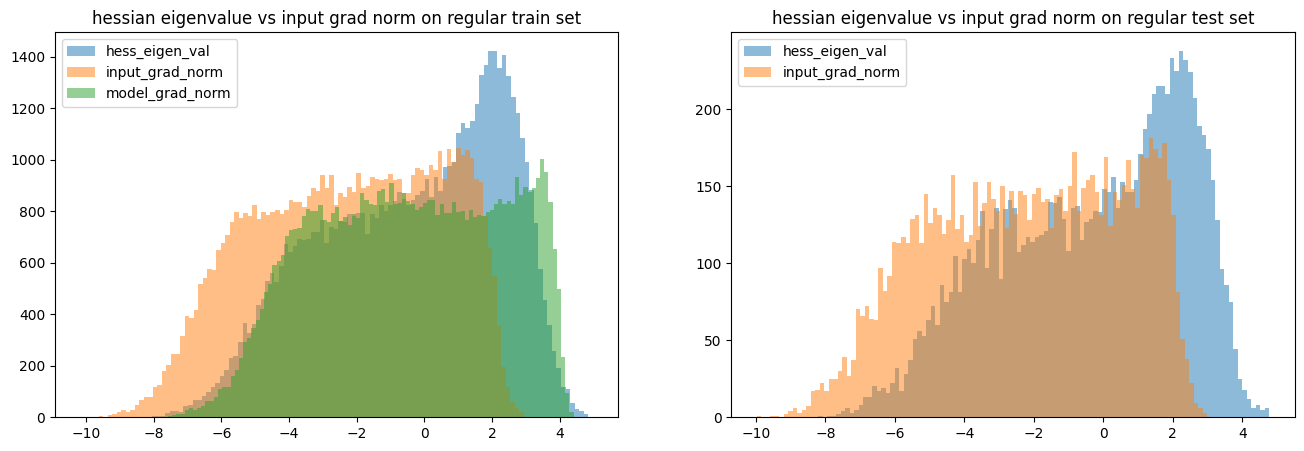

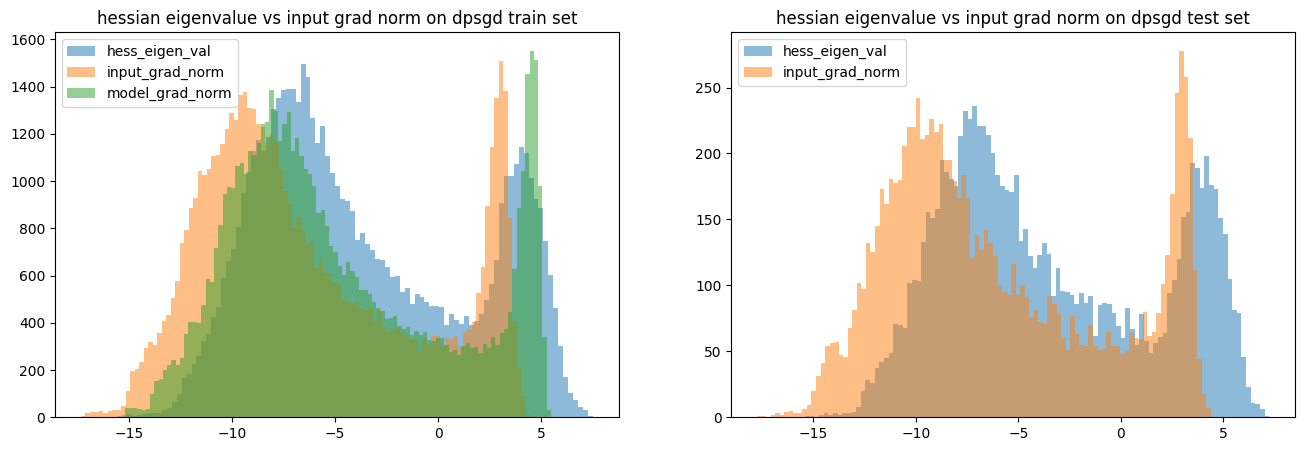

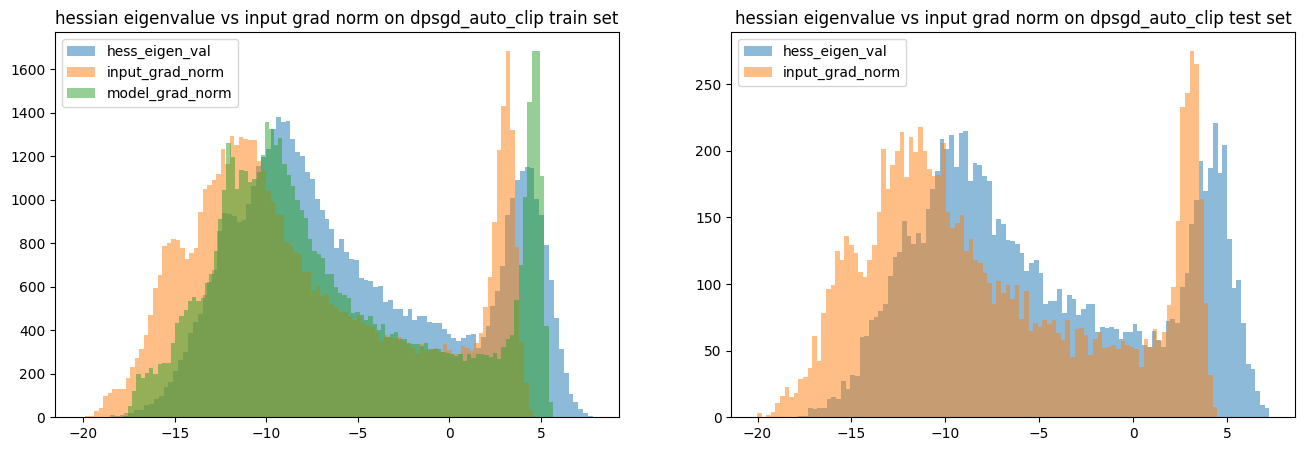

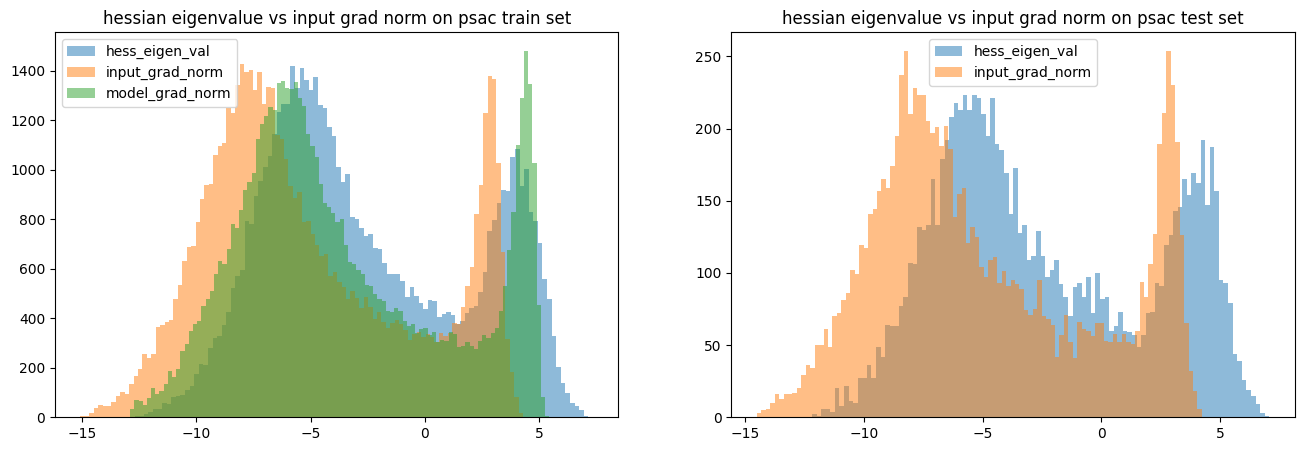

In [3]:

for method in methods:
    fig, ax = plt.subplots(1, 2)
    for id, mode in enumerate(["train", "test"]):
        result_df = result_df_dict[method][mode]
        ax[id].hist(x_axis_transform_func(result_df["hess_eigen_val"]), bins=100, alpha=0.5, label="hess_eigen_val")
        ax[id].hist(x_axis_transform_func(result_df["input_grad_norm"]), bins=100, alpha=0.5, label="input_grad_norm")
        if "param_grad_norm" in result_df.columns:
            ax[id].hist(x_axis_transform_func(result_df["param_grad_norm"]), bins=100, alpha=0.5, label="model_grad_norm")
        ax[id].set_title(f"hessian eigenvalue vs input grad norm on {method} {mode} set")
        ax[id].legend()
        fig.set_size_inches(16, 5)
    plt.show()
    plt.close()

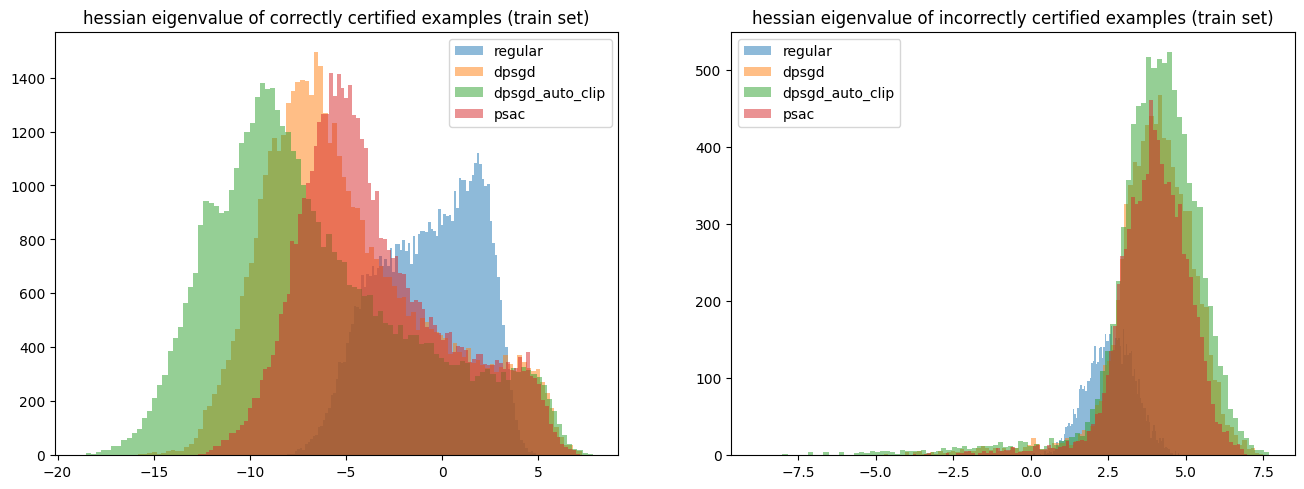

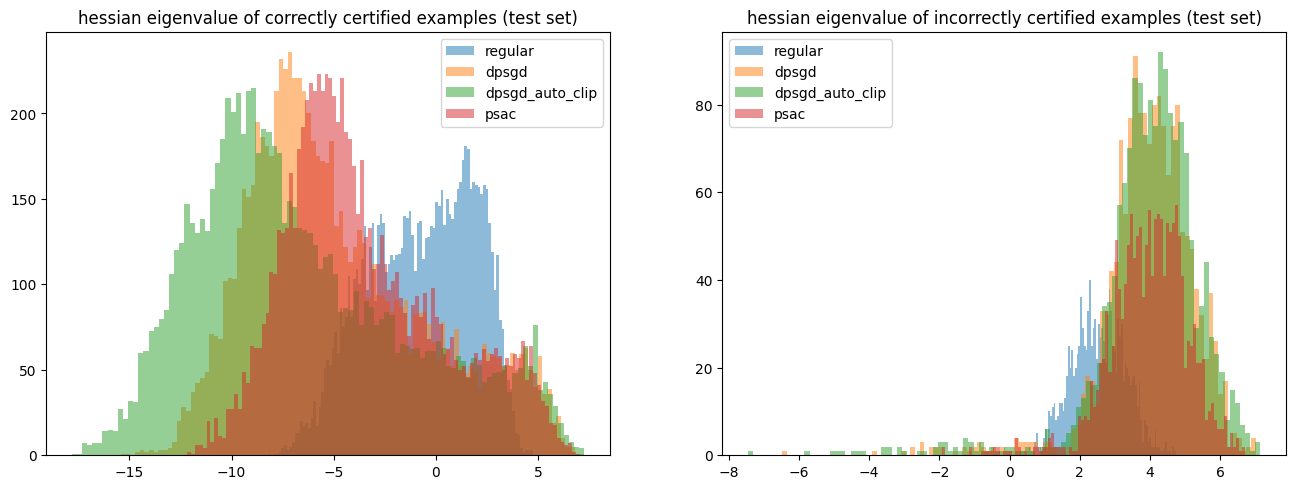

In [4]:
for mode in "train", "test":
        fig, ax = plt.subplots(1, 2)
        for method in methods:
                result_df = result_df_dict[method][mode]
                ax[0].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == True]["hess_eigen_val"]), bins=100, alpha=0.5, label=method)
        ax[0].set_title(f"hessian eigenvalue of correctly certified examples ({mode} set)")
        ax[0].legend()
        for method in methods:
                result_df = result_df_dict[method][mode]
                ax[1].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == False]["hess_eigen_val"]), bins=100, alpha=0.5, label=method)
        ax[1].set_title(f"hessian eigenvalue of incorrectly certified examples ({mode} set)")
        ax[1].legend()
        fig.set_size_inches(16, 5.5)

        plt.show()
        plt.close()


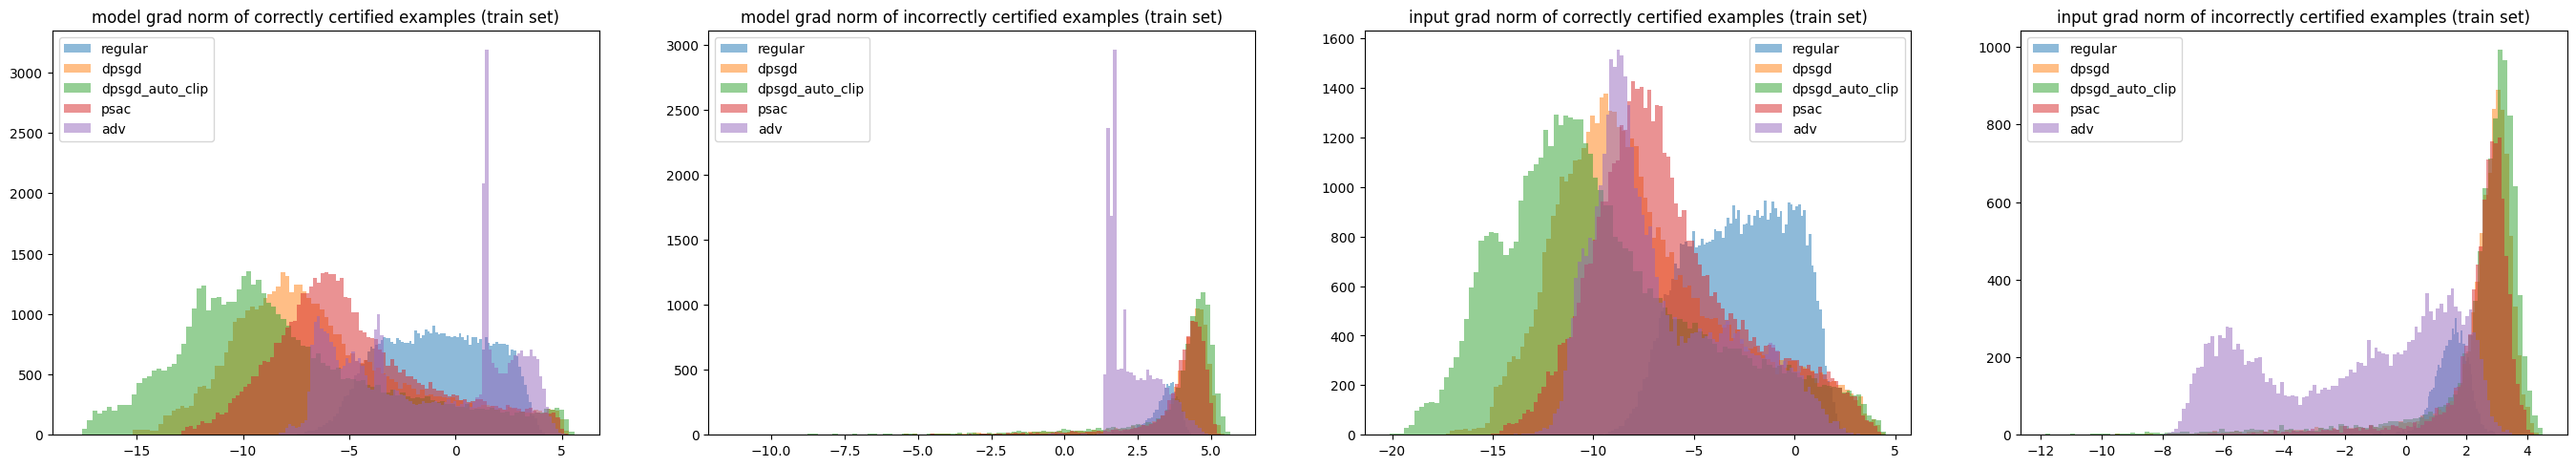

In [40]:
# in train_results_df, generate code for plotting the histogram of param_grad_norm for correct==True and correct==False:
mode = "train"

fig, ax = plt.subplots(1, 4)
for method in methods:
    result_df = result_df_dict[method][mode]
    ax[0].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == True]["param_grad_norm"]), bins=100, alpha=0.5, label=method)
    ax[0].set_title(f"model grad norm of correctly certified examples ({mode} set)")
ax[0].legend()
for method in methods:
    result_df = result_df_dict[method][mode]
    ax[1].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == False]["param_grad_norm"]), bins=100, alpha=0.5, label=method)
    ax[1].set_title(f"model grad norm of incorrectly certified examples ({mode} set)")
ax[1].legend()

for method in methods:
    result_df = result_df_dict[method][mode]
    ax[2].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == True]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
ax[2].set_title(f"input grad norm of correctly certified examples ({mode} set)")
ax[2].legend()
for method in methods:
    result_df = result_df_dict[method][mode]
    ax[3].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == False]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
ax[3].set_title(f"input grad norm of incorrectly certified examples ({mode} set)")
ax[3].legend()
fig.set_size_inches(34, 5.5)
plt.show()
plt.close()



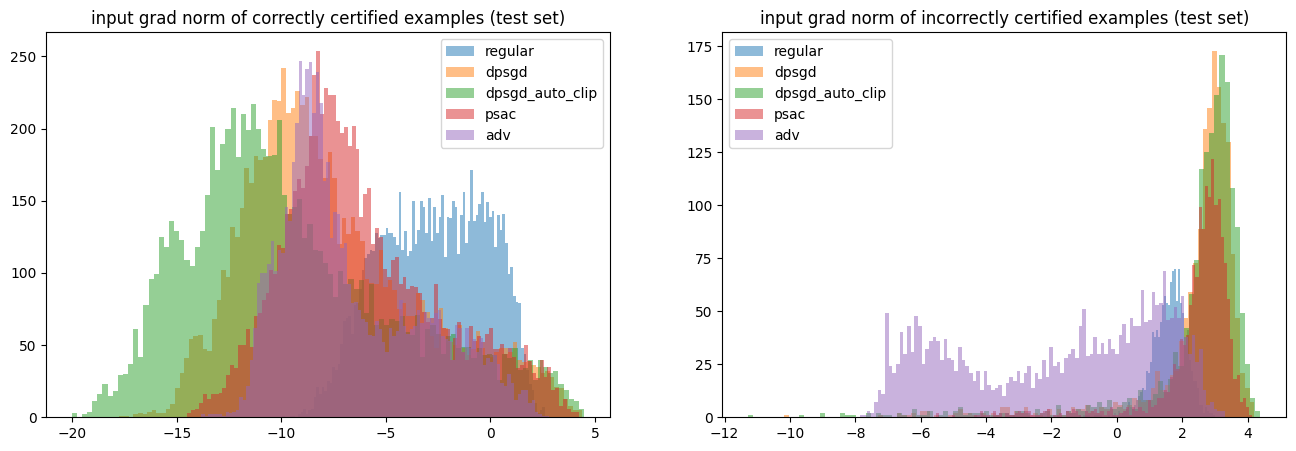

In [41]:
mode = "test"

fig, ax = plt.subplots(1, 2)

for method in methods:
    result_df = result_df_dict[method][mode]
    ax[0].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == True]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
ax[0].set_title(f"input grad norm of correctly certified examples ({mode} set)")
ax[0].legend()
for method in methods:
    result_df = result_df_dict[method][mode]
    ax[1].hist(x_axis_transform_func(result_df[result_df["smoothed_correct"] == False]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
ax[1].set_title(f"input grad norm of incorrectly certified examples ({mode} set)")
ax[1].legend()
fig.set_size_inches(16, 5)
plt.show()
plt.close()

pgd_0.0005, training set


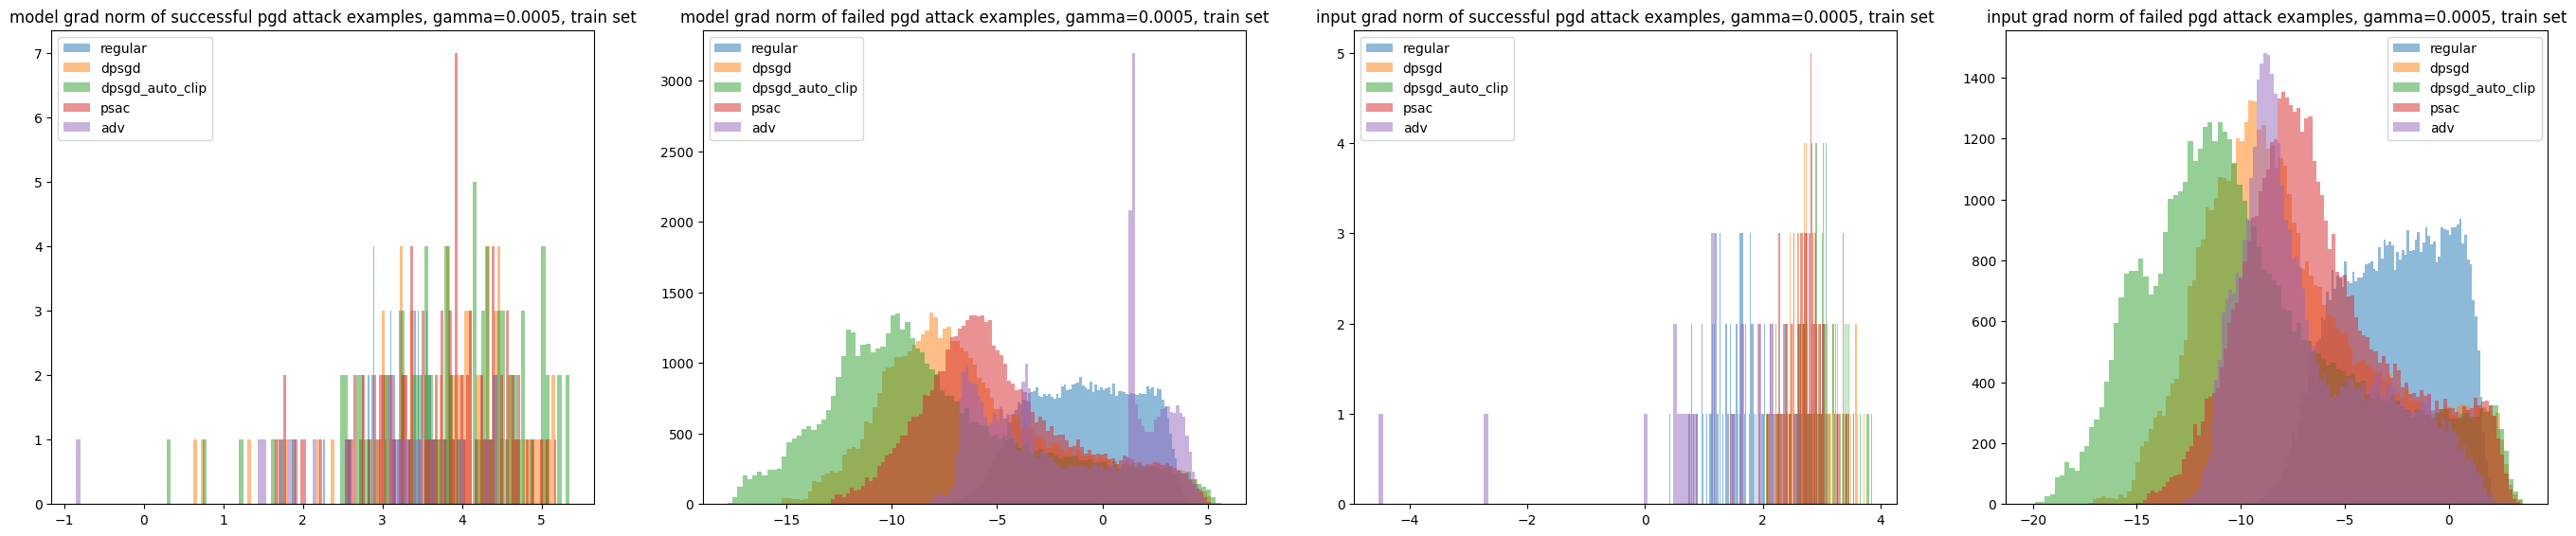

pgd_0.01, training set


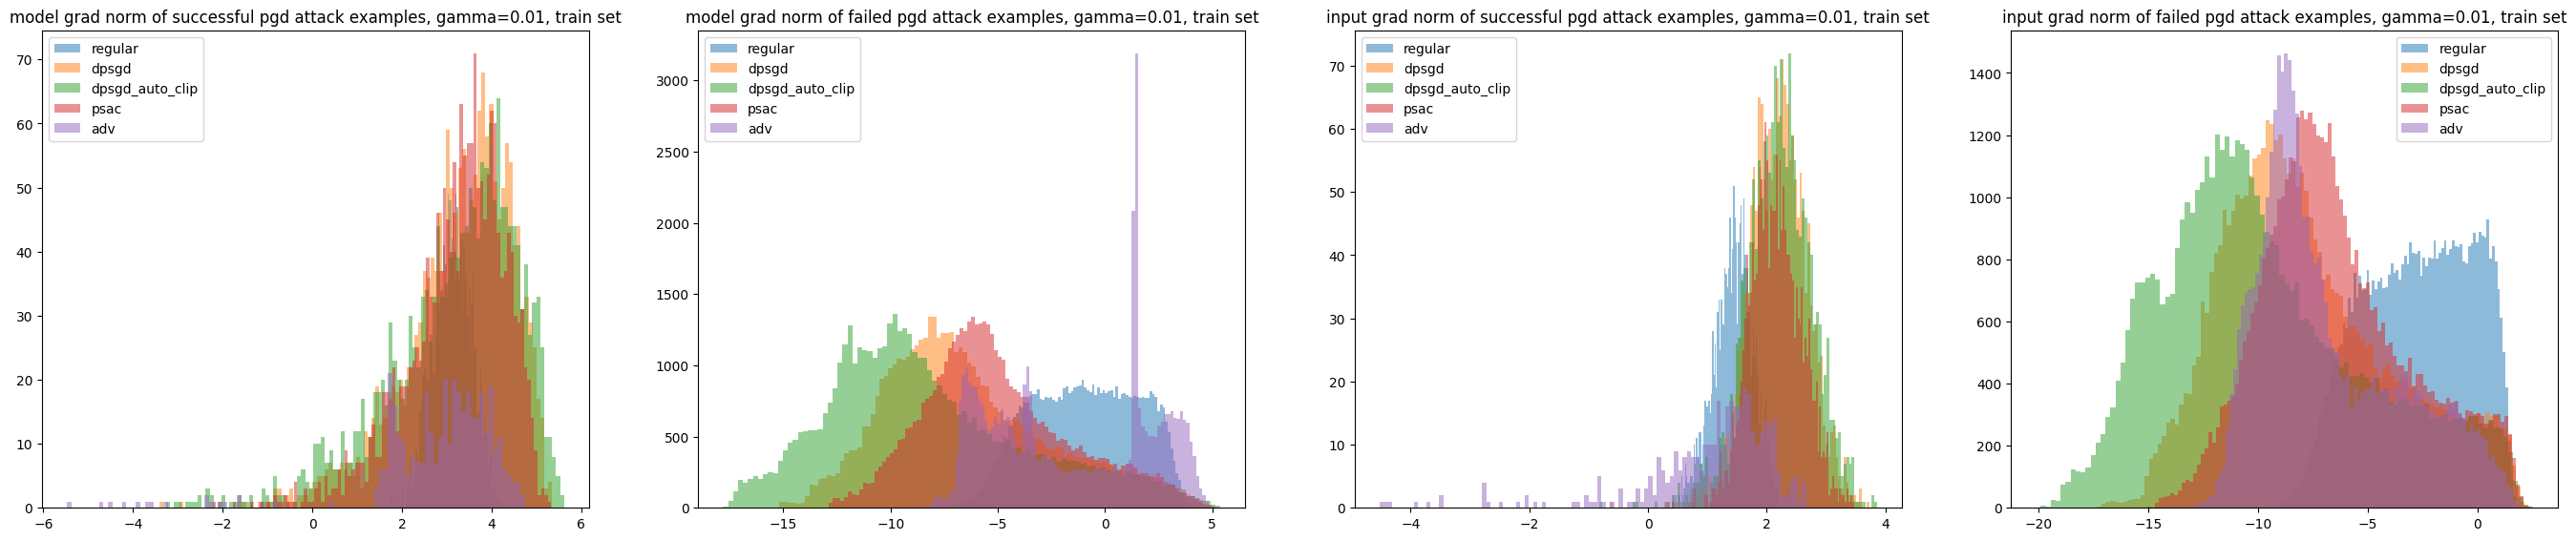

pgd_0.1, training set


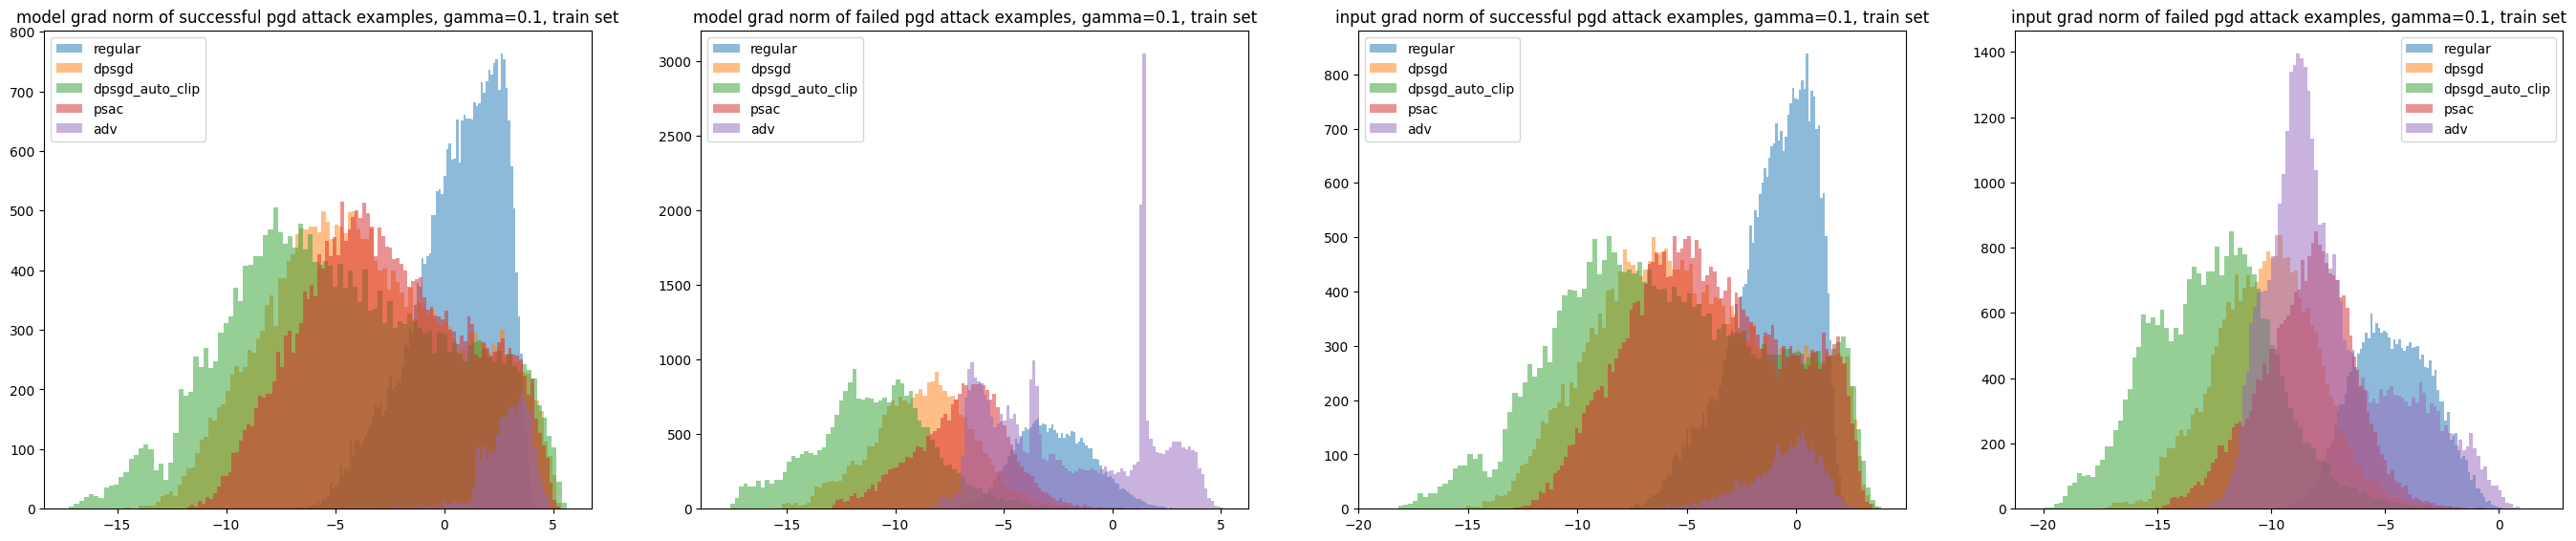

pgd_0.5, training set


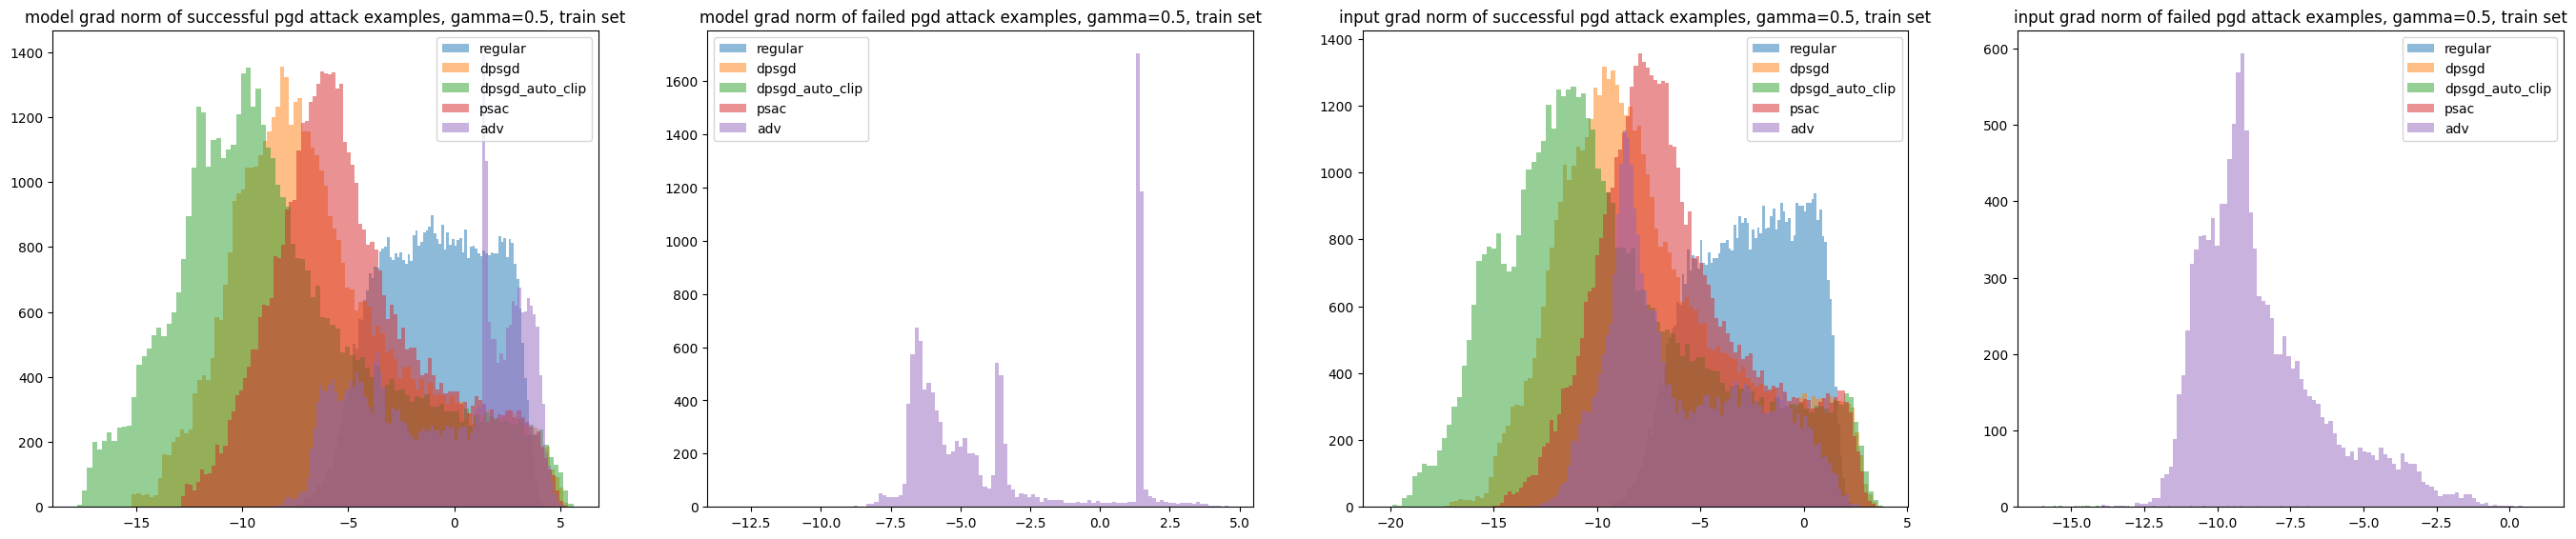

pgd_1, training set


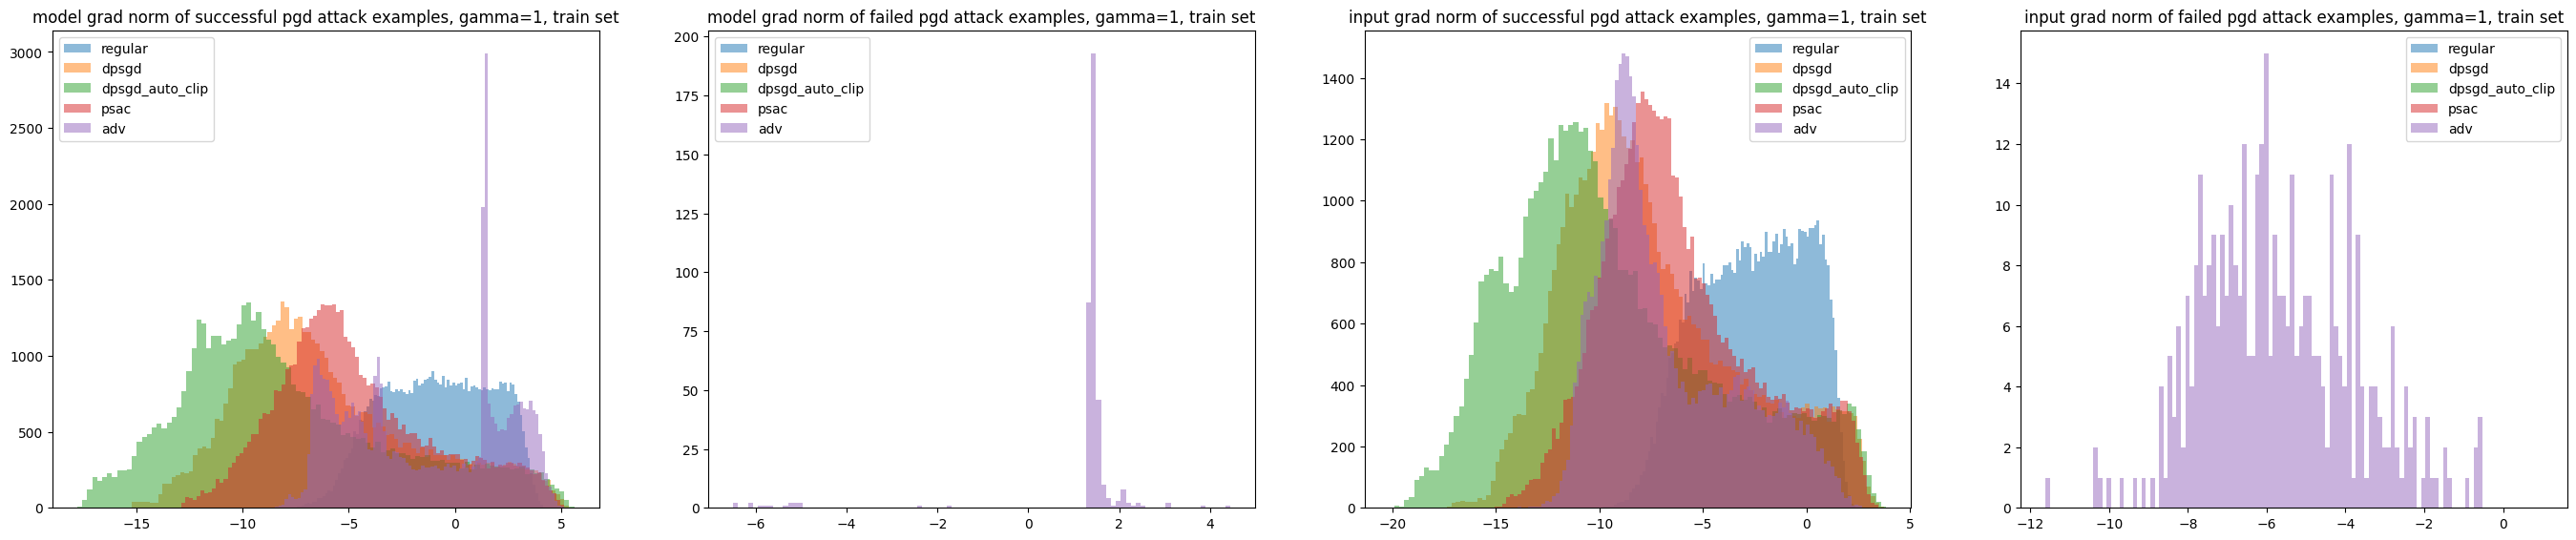

In [42]:
# param_grad_norm and input grad norm for pgd attacks
for i in ['pgd_0.0005', 'pgd_0.01','pgd_0.1', 'pgd_0.5', 'pgd_1']:
       print(f"{i}, training set")
       
       attack = i.split("_")[0]
       gamma = i.split("_")[1]

       fig, ax = plt.subplots(1, 4)
       mode = "train"
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[0].hist(x_axis_transform_func(result_df[result_df[i] == True]["param_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[0].set_title(f"model grad norm of successful {attack} attack examples, gamma={gamma}, {mode} set")
       ax[0].legend()
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[1].hist(x_axis_transform_func(result_df[result_df[i] == False]["param_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[1].set_title(f"model grad norm of failed {attack} attack examples, gamma={gamma}, {mode} set")
       ax[1].legend()

       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[2].hist(x_axis_transform_func(result_df[result_df[i] == True]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[2].set_title(f"input grad norm of successful {attack} attack examples, gamma={gamma}, {mode} set")
       ax[2].legend()
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[3].hist(x_axis_transform_func(result_df[result_df[i] == False]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[3].set_title(f"input grad norm of failed {attack} attack examples, gamma={gamma}, {mode} set")
       ax[3].legend()
       fig.set_size_inches(34, 6.5)
       plt.show()
       plt.close()
              


pgd_0.0005, test set


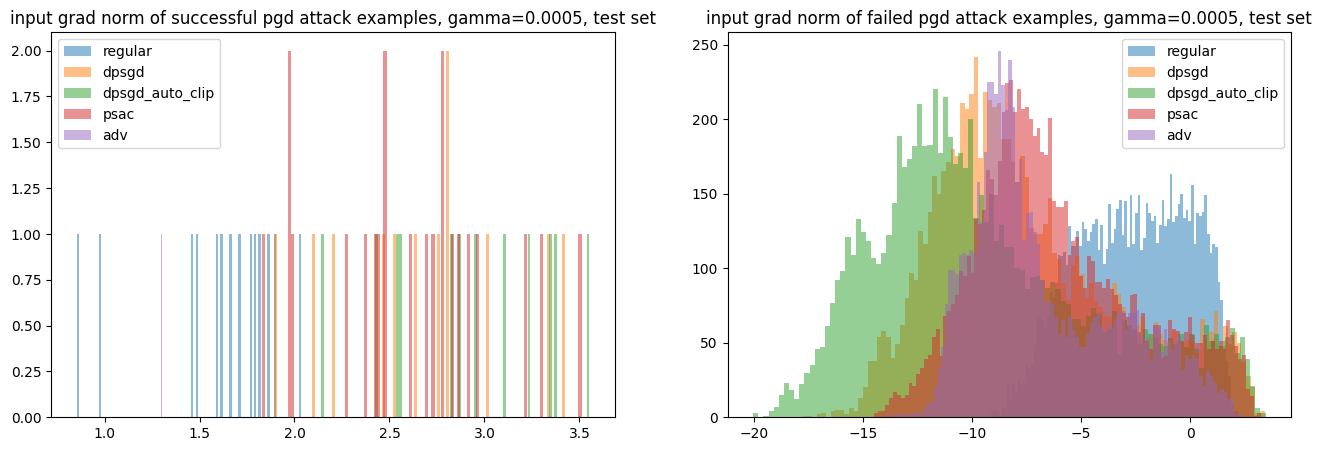

pgd_0.01, test set


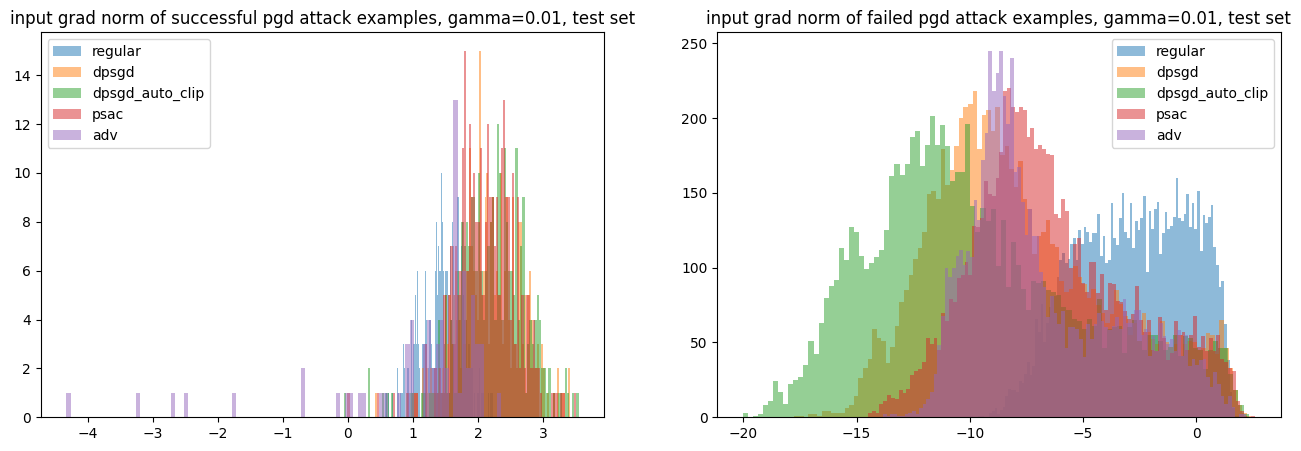

pgd_0.1, test set


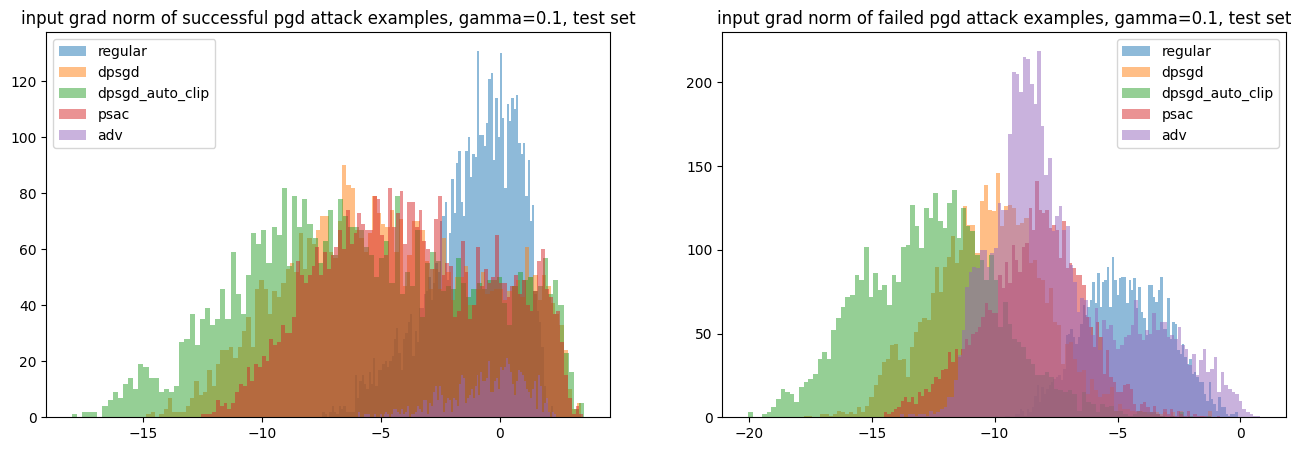

pgd_0.5, test set


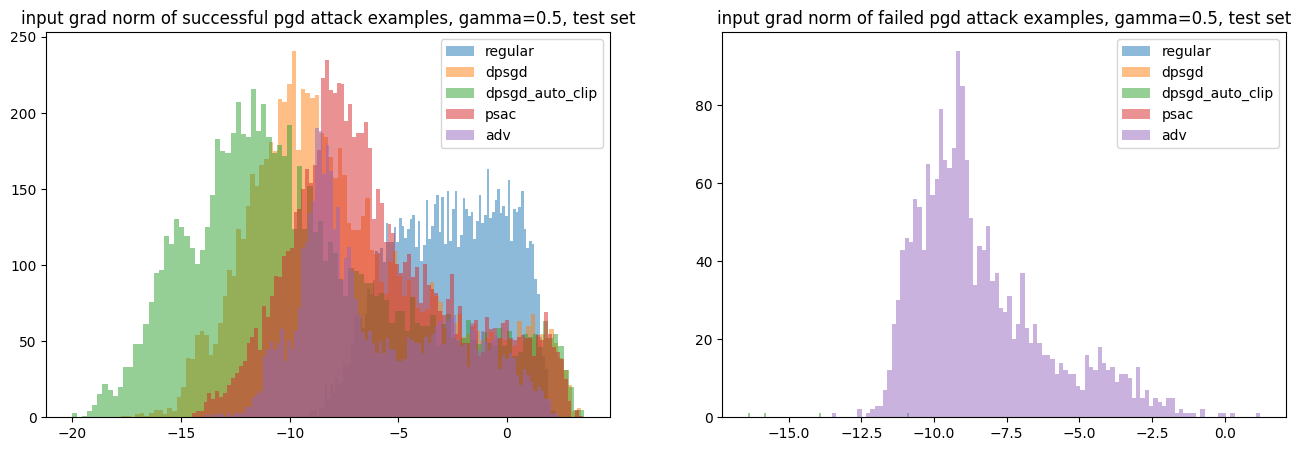

pgd_1, test set


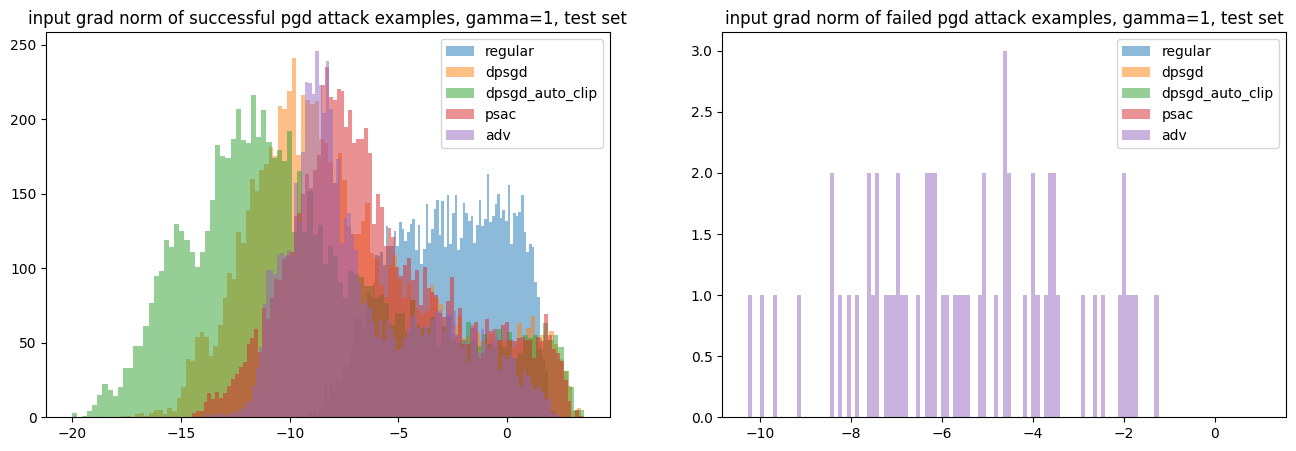

In [43]:
# param_grad_norm and input grad norm for pgd attacks
for i in ['pgd_0.0005', 'pgd_0.01','pgd_0.1', 'pgd_0.5', 'pgd_1']:
       print(f"{i}, test set")
       
       attack = i.split("_")[0]
       gamma = i.split("_")[1]

       fig, ax = plt.subplots(1, 2)
       mode = "test"
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[0].hist(x_axis_transform_func(result_df[result_df[i] == True]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[0].set_title(f"input grad norm of successful {attack} attack examples, gamma={gamma}, {mode} set")
       ax[0].legend()
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[1].hist(x_axis_transform_func(result_df[result_df[i] == False]["input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[1].set_title(f"input grad norm of failed {attack} attack examples, gamma={gamma}, {mode} set")
       ax[1].legend()
       fig.set_size_inches(16, 5)

       plt.show()
       plt.close()


pgd_0.0005, test set


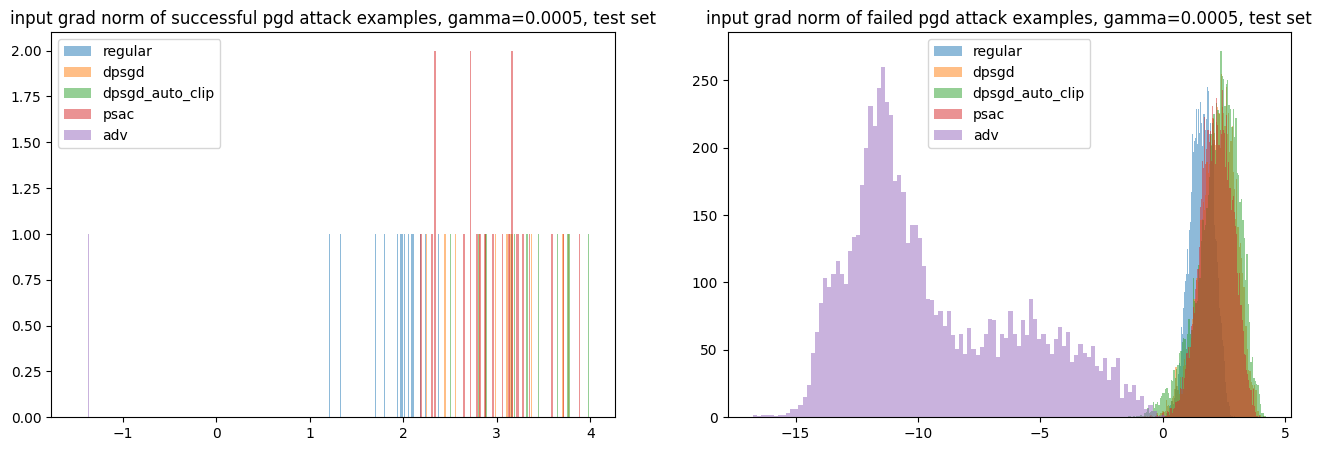

pgd_0.01, test set


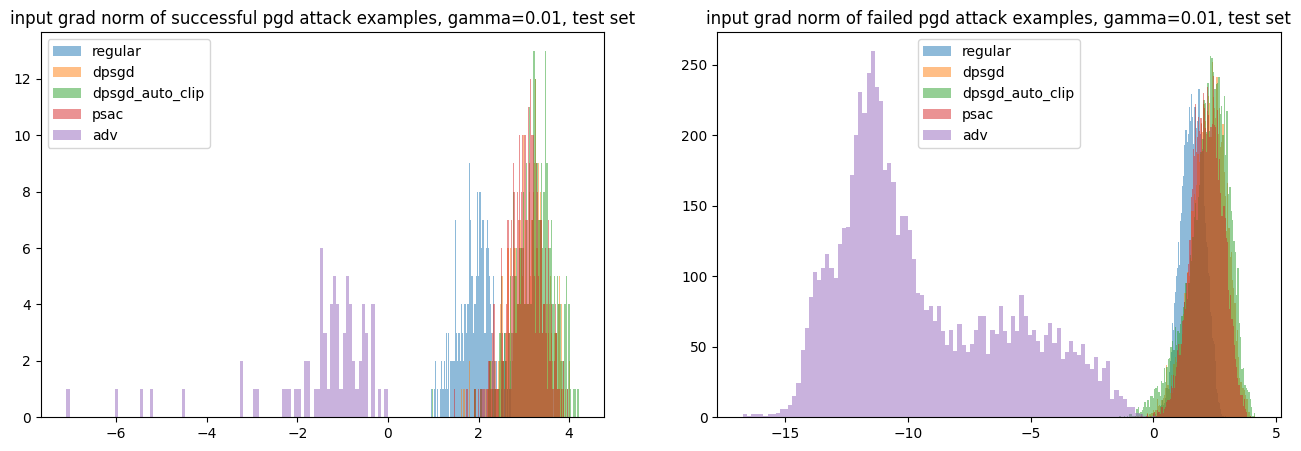

pgd_0.1, test set


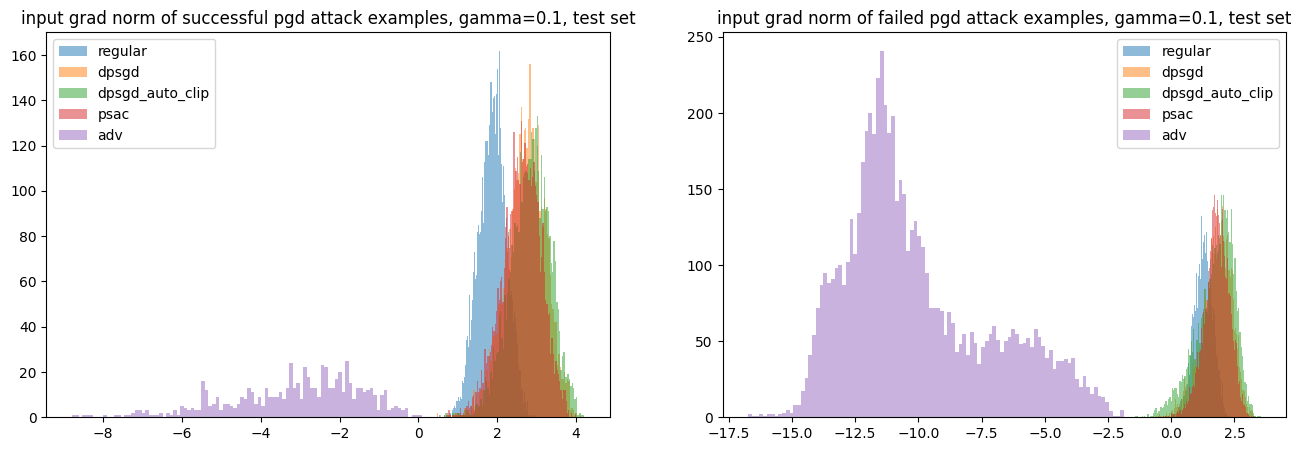

pgd_0.5, test set


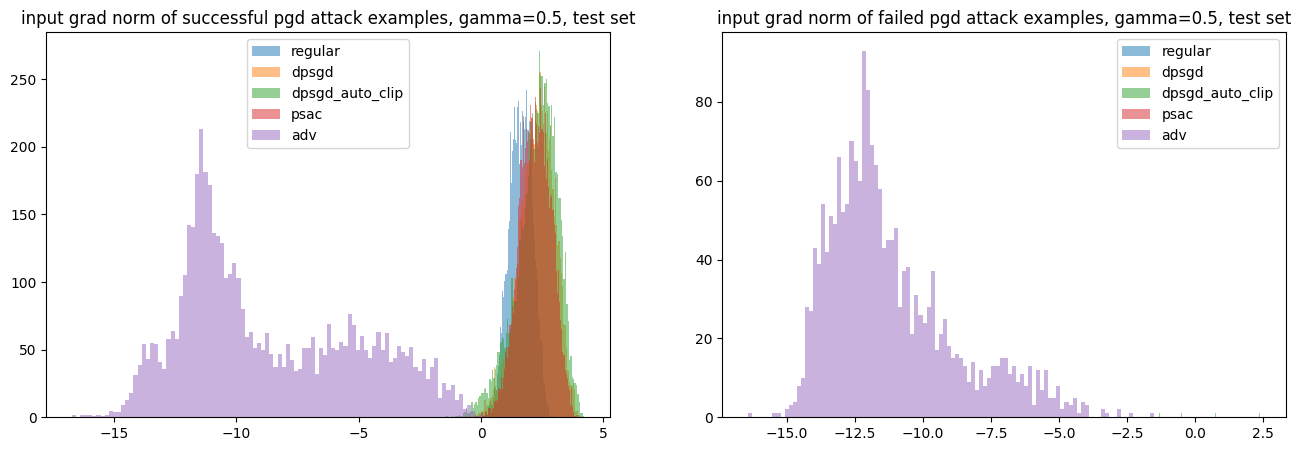

pgd_1, test set


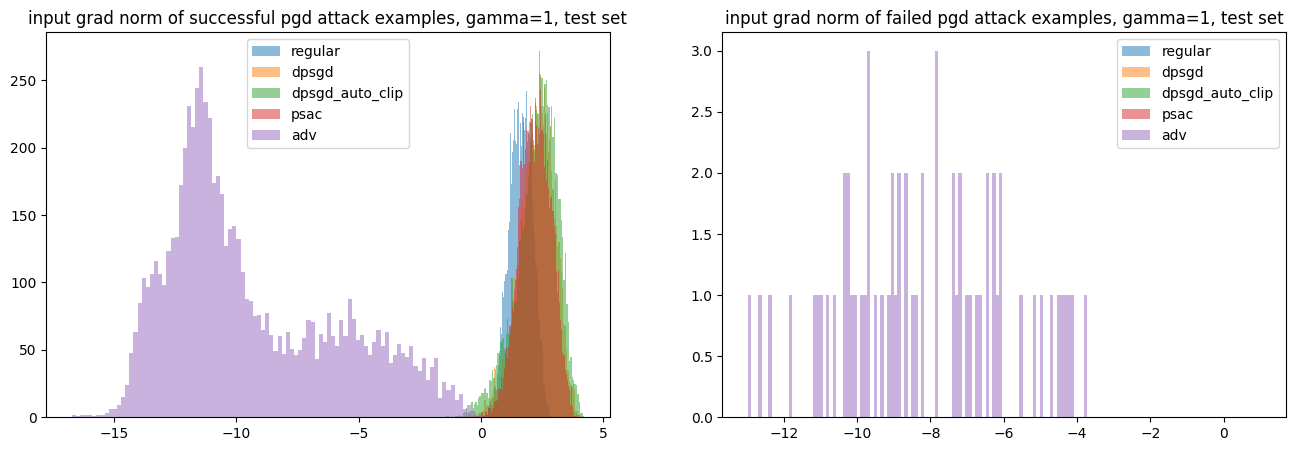

In [44]:
# param_grad_norm and input grad norm for pgd attacks
for i in ['pgd_0.0005', 'pgd_0.01','pgd_0.1', 'pgd_0.5', 'pgd_1']:
       print(f"{i}, test set")
       
       attack = i.split("_")[0]
       gamma = i.split("_")[1]
       

       fig, ax = plt.subplots(1, 2)
       mode = "test"
       for method in methods:
              result_df = result_df_dict[method][mode]
            #   print(result_df.columns)
              ax[0].hist(x_axis_transform_func(result_df[result_df[i] == True]["normlized_input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[0].set_title(f"input grad norm of successful {attack} attack examples, gamma={gamma}, {mode} set")
       ax[0].legend()
       for method in methods:
              result_df = result_df_dict[method][mode]
              ax[1].hist(x_axis_transform_func(result_df[result_df[i] == False]["normlized_input_grad_norm"]), bins=100, alpha=0.5, label=method)
       ax[1].set_title(f"input grad norm of failed {attack} attack examples, gamma={gamma}, {mode} set")
       ax[1].legend()
       fig.set_size_inches(16, 5)

       plt.show()
       plt.close()
